In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
# Confirm we do not have any null values in our data
df = pd.read_csv("mlb_games.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216 entries, 0 to 1215
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1216 non-null   int64  
 1   game_date          1216 non-null   object 
 2   home_team          1216 non-null   object 
 3   away_team          1216 non-null   object 
 4   home_starter_era   1216 non-null   float64
 5   away_starter_era   1216 non-null   float64
 6   home_starter_whip  1216 non-null   float64
 7   away_starter_whip  1216 non-null   float64
 8   home_starter_hr    1216 non-null   float64
 9   away_starter_hr    1216 non-null   float64
 10  home_starter_k     1216 non-null   float64
 11  away_starter_k     1216 non-null   float64
 12  home_starter_r     1216 non-null   float64
 13  away_starter_r     1216 non-null   float64
 14  home_team_era      1216 non-null   float64
 15  away_team_era      1216 non-null   float64
 16  home_pitcher_obp   1216 

In [2]:
# Add some additional data using some of the data stored (Feature Engineering)
df["era_diff"] = df["home_starter_era"] - df["away_starter_era"]
df["ops_diff"] = df["home_ops"] - df["away_ops"]
df["line_vs_combined_ops"] = df["line"] - (df["home_ops"] + df["away_ops"])

In [3]:
# Get streak data to show "Over" trends
# Step 1: Create long format for home and away teams
home_df = df[["game_date", "home_team", "result"]].copy()
home_df.columns = ["game_date", "team", "result"]

away_df = df[["game_date", "away_team", "result"]].copy()
away_df.columns = ["game_date", "team", "result"]

# Combine both into a single team-based DataFrame
long_df = pd.concat([home_df, away_df], ignore_index=True)

# Ensure date is datetime for sorting
long_df["game_date"] = pd.to_datetime(long_df["game_date"])
long_df.sort_values(["team", "game_date"], inplace=True)

# Step 2: Convert result to binary
long_df["is_over"] = (long_df["result"] == "Over").astype(int)

# Step 3: Calculate over streak per team
def compute_streak(series):
    streaks = []
    count = 0
    for val in series:
        if val == 1:
            count += 1
        else:
            count = 0
        streaks.append(count)
    return streaks

long_df["over_streak"] = long_df.groupby("team")["is_over"].transform(compute_streak)

# ✅ At this point long_df has: team, game_date, result, is_over, over_streak

# Step 4: Merge over streaks back to original df
df["game_date"] = pd.to_datetime(df["game_date"])

# Merge home team streak
home_streaks = long_df[["team", "game_date", "over_streak"]].rename(
    columns={"team": "home_team", "over_streak": "home_over_streak"}
)
df = df.merge(home_streaks, on=["game_date", "home_team"], how="left")

# Merge away team streak
away_streaks = long_df[["team", "game_date", "over_streak"]].rename(
    columns={"team": "away_team", "over_streak": "away_over_streak"}
)
df = df.merge(away_streaks, on=["game_date", "away_team"], how="left")

In [4]:
# Show distribution of the data in our set, excluding id since that is just for our sql database
df_excluded = df.drop(['id', 'game_date'], axis=1)
df_excluded.describe()

,home_starter_era,away_starter_era,home_starter_whip,away_starter_whip,home_starter_hr,away_starter_hr,home_starter_k,away_starter_k,home_starter_r,away_starter_r,...,home_obp,away_obp,home_ops,away_ops,line,era_diff,ops_diff,line_vs_combined_ops,home_over_streak,away_over_streak
count,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,...,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000
mean,4.118882,4.155896,1.282829,1.289317,1.229383,1.222171,8.187220,8.118840,4.424433,4.452895,...,0.314556,0.314187,0.706921,0.706274,8.449836,-0.037015,0.000647,7.036641,0.849507,0.873355
std,1.501140,1.514862,0.232994,0.237388,0.540146,0.512818,1.699408,1.669796,1.580228,1.582964,...,0.019474,0.020132,0.056228,0.057237,0.861590,2.147897,0.079664,0.851859,1.293688,1.356738
min,0.000000,0.760000,0.500000,0.810000,0.000000,0.000000,4.000000,4.070000,0.710000,1.140000,...,0.240000,0.238000,0.487000,0.458000,6.000000,-15.400000,-0.426000,4.641000,0.000000,0.000000
25%,3.217500,3.177500,1.140000,1.140000,0.940000,0.930000,7.000000,6.930000,3.480000,3.480000,...,0.303000,0.303000,0.673000,0.676000,8.000000,-1.382500,-0.049000,6.550750,0.000000,0.000000
50%,4.070000,4.110000,1.290000,1.290000,1.150000,1.150000,7.905000,7.875000,4.275000,4.340000,...,0.315000,0.315000,0.704000,0.704000,8.500000,-0.040000,-0.002000,7.053000,0.000000,0.000000
75%,4.780000,4.790000,1.410000,1.420000,1.480000,1.480000,9.290000,9.220000,5.180000,5.210000,...,0.328000,0.327000,0.738000,0.738000,9.000000,1.165000,0.051250,7.543000,1.000000,1.000000
max,16.780000,19.500000,2.920000,3.670000,5.630000,5.140000,14.050000,14.050000,16.780000,21.000000,...,0.381000,0.384000,1.100000,1.012000,12.500000,13.480000,0.347000,11.046000,8.000000,8.000000


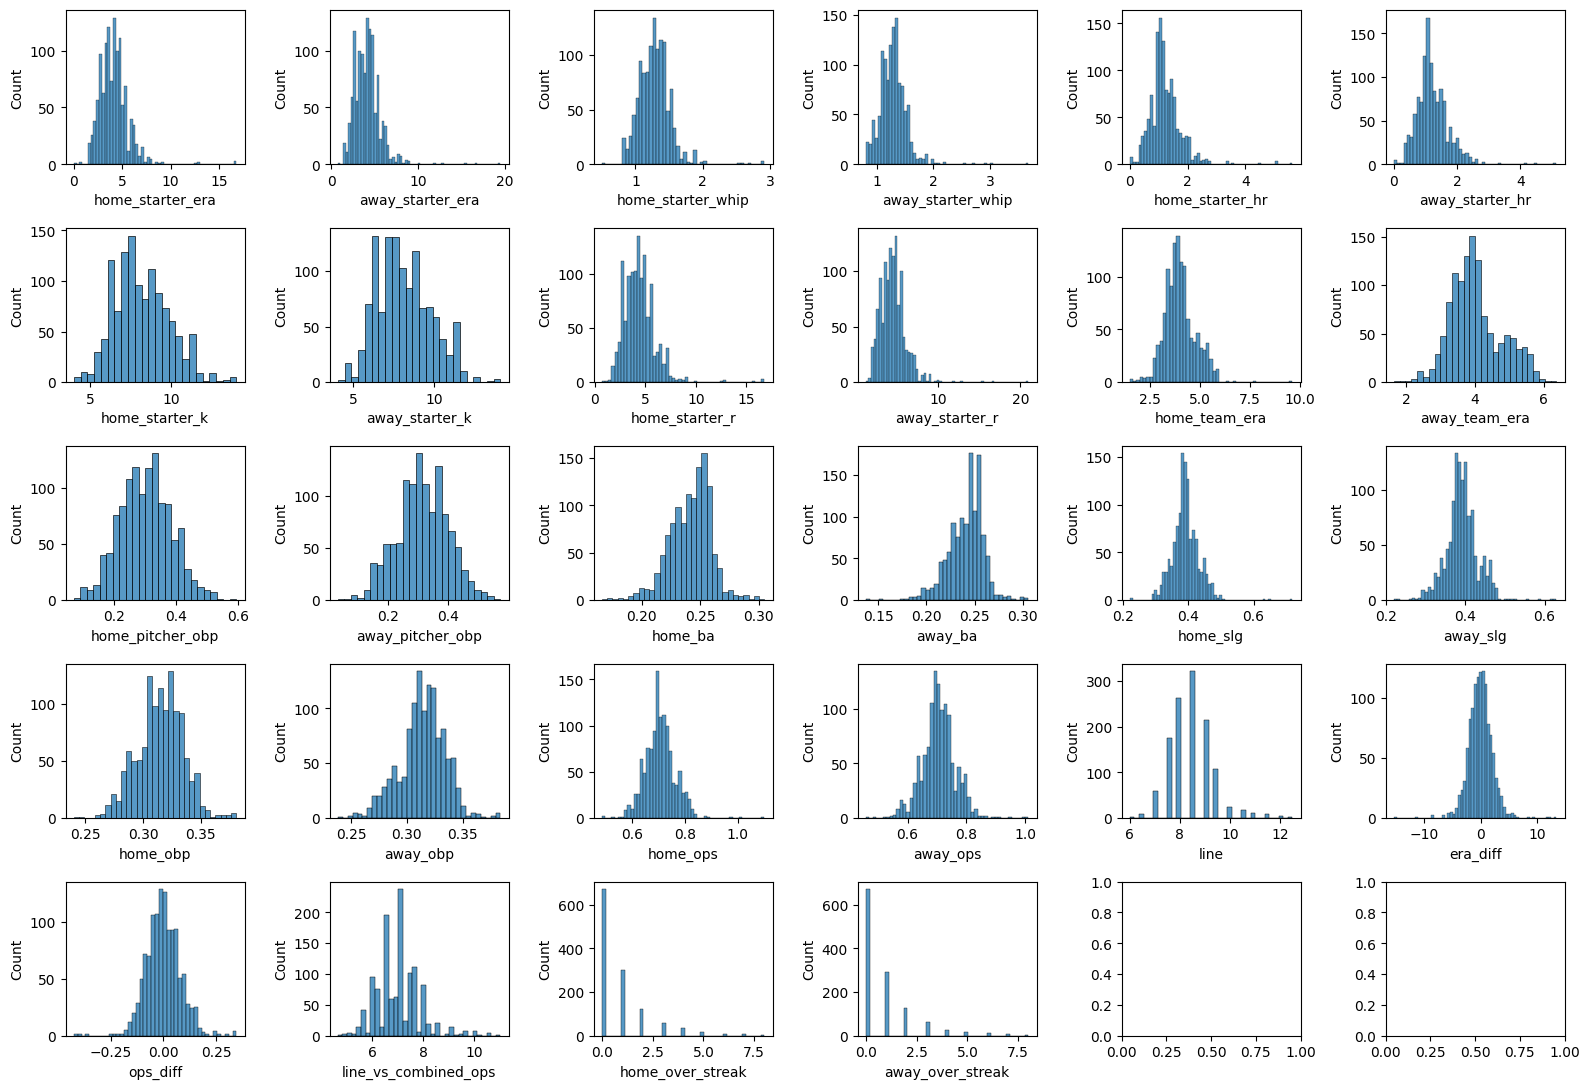

In [5]:
import matplotlib.pyplot as plt
import seaborn as sb
# Better visualize the distributions through boxplots
features = list(df_excluded.select_dtypes(include = 'number').columns)
fig, ax = plt.subplots(5, 6, figsize=(16,11))

for i, col in enumerate(features):
  plt.subplot(5, 6, i + 1)
  sb.histplot(df[col])
plt.tight_layout()
plt.show()

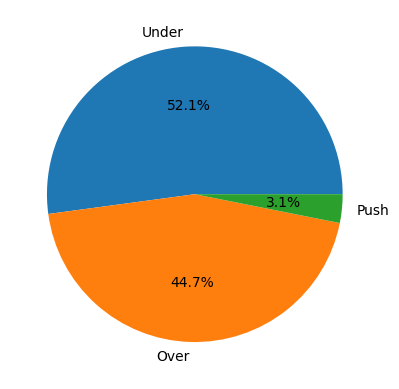

In [6]:
# Lets look at the distribution of over, push, and under
plt.pie(df['result'].value_counts().values,
        labels = df['result'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

In [7]:
# We can also analyze the average of our target to see around where the features are for an over or under game
df_excluded.groupby('result').mean(numeric_only=True)

,home_starter_era,away_starter_era,home_starter_whip,away_starter_whip,home_starter_hr,away_starter_hr,home_starter_k,away_starter_k,home_starter_r,away_starter_r,...,home_obp,away_obp,home_ops,away_ops,line,era_diff,ops_diff,line_vs_combined_ops,home_over_streak,away_over_streak
result,,,,,,,,,,,,,,,,,,,,,
Over,4.327960,4.286085,1.313272,1.307353,1.283346,1.254835,8.110404,8.085294,4.678235,4.589945,...,0.315759,0.316680,0.711362,0.715127,8.467831,0.041875,-0.003765,7.041342,1.898897,1.952206
Push,4.120526,4.271053,1.268158,1.281842,1.235789,1.197632,8.350789,8.288421,4.449737,4.543158,...,0.318684,0.315684,0.709789,0.709579,8.368421,-0.150526,0.000211,6.949053,0.000000,0.000000
Under,3.939385,4.037287,1.257587,1.274290,1.182697,1.195615,8.243328,8.137461,4.205142,4.329890,...,0.313276,0.311957,0.702938,0.698479,8.439274,-0.097902,0.004459,7.037856,0.000000,0.000000


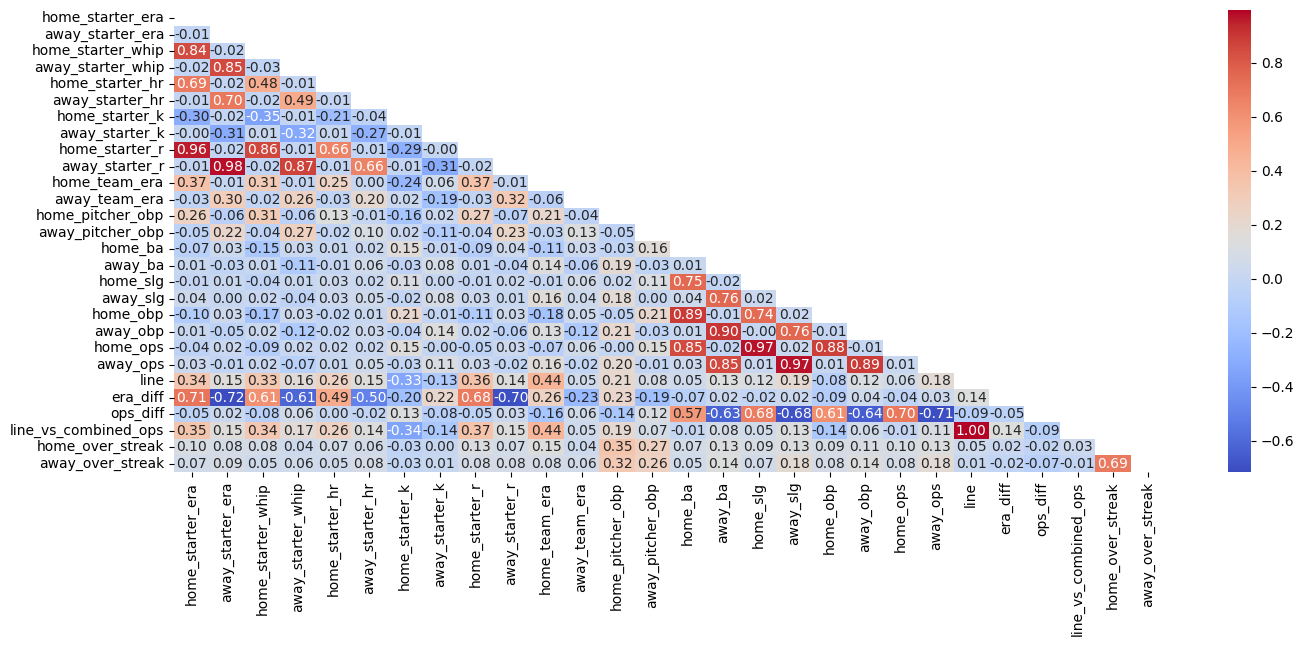

In [8]:
import numpy as np
# Correlation Matrix to see which features are the most are similar
correlation_matrix = df_excluded.select_dtypes(include='number').corr()
mask = np.zeros_like(correlation_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(16,6))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.show()

In [9]:
# Drop highly correlated features to avoid redundancy
# Generally removed one of two features whose correlation was over 0.8, but kept some based on personal preference
df = df.drop(["home_starter_r", "away_starter_r", "line", "away_slg", "home_slg", "home_ba", "away_ba"], axis=1)

In [10]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Split the data into training and testing
features = df.drop(["result", "id", "home_team", "away_team", "game_date"], axis=1)
feature_names = features.columns
target = df["result"]

# Standardize Features
scaler = StandardScaler()
X = scaler.fit_transform(features)

y = LabelEncoder().fit_transform(target)
num_classes = len(np.unique(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)


In [17]:
# Classifiers to test
models = {
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBClassifier": XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100),
}

# Train and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n==== {name} ====")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\n")
    print(classification_report(y_test, y_pred))

stack = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier()),
        ('gb', GradientBoostingClassifier()),
        ('xgb', XGBClassifier())
    ],
    final_estimator=LogisticRegression()
)
stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)
print(f"\n==== Stack Classifier ====")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))


==== Random Forest ====
Accuracy: 0.9631147540983607


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       121
           1       0.00      0.00      0.00         9
           2       0.93      1.00      0.96       114

    accuracy                           0.96       244
   macro avg       0.64      0.67      0.65       244
weighted avg       0.93      0.96      0.95       244


==== Gradient Boosting ====
Accuracy: 0.9631147540983607


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       121
           1       0.00      0.00      0.00         9
           2       0.93      1.00      0.96       114

    accuracy                           0.96       244
   macro avg       0.64      0.67      0.65       244
weighted avg       0.93      0.96      0.95       244


==== XGBClassifier ====
Accuracy: 0.9631147540983607


              precision    recall  f1-score   support

           

In [18]:
print("\n==== Pytorch Neural Network ====")

class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

# Convert to pytorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Dataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Model, loss, optimizer
model = MLP(X.shape[1], num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 32
for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

# Evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, y_pred_nn = torch.max(outputs, 1)

print(f"PyTorch Accuracy: {accuracy_score(y_test, y_pred_nn):.4f}")
print(classification_report(y_test, y_pred_nn))


==== Pytorch Neural Network ====
PyTorch Accuracy: 0.9631
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       121
           1       0.00      0.00      0.00         9
           2       0.93      1.00      0.96       114

    accuracy                           0.96       244
   macro avg       0.64      0.67      0.65       244
weighted avg       0.93      0.96      0.95       244



In [16]:
import pickle
# Save the Random Forest model
model = RandomForestClassifier()
model.fit(X_train, y_train)

filename = "model.pkl"
with open(filename, 'wb') as file:
    pickle.dump(model, file)